# ***Zero Shot Learning With Image Classification***


## ***Import Libraries***

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import pandas as pd
import gensim as gs
import sklearn.metrics.pairwise as skpairwise
import gensim.downloader as gdownloader
from matplotlib import pyplot as plt
from typing import List, Tuple, Dict

For our image we used the cifar100 dataset.The dataset consists of 60000 colored images (50000 training and 10000 test) of 32 × 32 pixels in 100 classes grouped into 20 superclasses. Each image has a fine label (class) and a coarse label (superclass)

First lets load our images from tensorflow datasets with fine labels:

In [27]:
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None
(x_train, y_train), (x_test, y_test) = (
    tf.keras.datasets.cifar100.load_data(label_mode="fine"))

Next let's validate the number of images, fine labels and coarse labels:

In [28]:
print(f"Train images shape: {x_train.shape}")
print(f"Train fine labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test fine labels shape: {y_test.shape}")

Train images shape: (50000, 32, 32, 3)
Train fine labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test fine labels shape: (10000, 1)


As we can see we have the correct number of images with shape 32 × 32. 
Let's take a look at the fine labels:

In [29]:
print(np.unique(np.append(y_train, y_test)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


As we can see we have 100 integer values representing our fine labels.Now we will create a list such that each integer is the index of its string representation in that list:

In [30]:
fine_labels: List[str] = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver',
    'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
    'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can',
    'castle', 'caterpillar', 'cattle', 'chair',
    'chimpanzee', 'clock', 'cloud', 'cockroach',
    'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
    'girl', 'hamster', 'house', 'kangaroo',
    'computer_keyboard', 'lamp', 'lawn_mower',
    'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy',
    'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road',
    'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train',
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale',
    'willow_tree', 'wolf', 'woman', 'worm'
]

Now let's create the fine string labels arrays:

In [31]:
y_train_str: np.ndarray = np.array(list(map(lambda x: np.array(
    [fine_labels[x[0]]]), y_train)))
y_test_str: np.ndarray = np.array(list(map(lambda x: np.array(
    [fine_labels[x[0]]]), y_test)))

print(f"Train fine labels strings shape: {y_train_str.shape}\n")
print(f"Test fine labels strings shape: {y_test_str.shape}\n")
print("All the fine labels strings values from the arrays:"
      f"\n{np.unique(np.append(y_train_str, y_test_str))}")

Train fine labels strings shape: (50000, 1)

Test fine labels strings shape: (10000, 1)

All the fine labels strings values from the arrays:
['apple' 'aquarium_fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can'
 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud'
 'cockroach' 'computer_keyboard' 'couch' 'crab' 'crocodile' 'cup'
 'dinosaur' 'dolphin' 'elephant' 'flatfish' 'forest' 'fox' 'girl'
 'hamster' 'house' 'kangaroo' 'lamp' 'lawn_mower' 'leopard' 'lion'
 'lizard' 'lobster' 'man' 'maple_tree' 'motorcycle' 'mountain' 'mouse'
 'mushroom' 'oak_tree' 'orange' 'orchid' 'otter' 'palm_tree' 'pear'
 'pickup_truck' 'pine_tree' 'plain' 'plate' 'poppy' 'porcupine' 'possum'
 'rabbit' 'raccoon' 'ray' 'road' 'rocket' 'rose' 'sea' 'seal' 'shark'
 'shrew' 'skunk' 'skyscraper' 'snail' 'snake' 'spider' 'squirrel'
 'streetcar' 'sunflower' 'sweet_pepper' 'table' 'tank' 'telephone'
 'television' 'tiger' 'tractor' 

Now that we have the fine labels as string let's visualize some of our data:

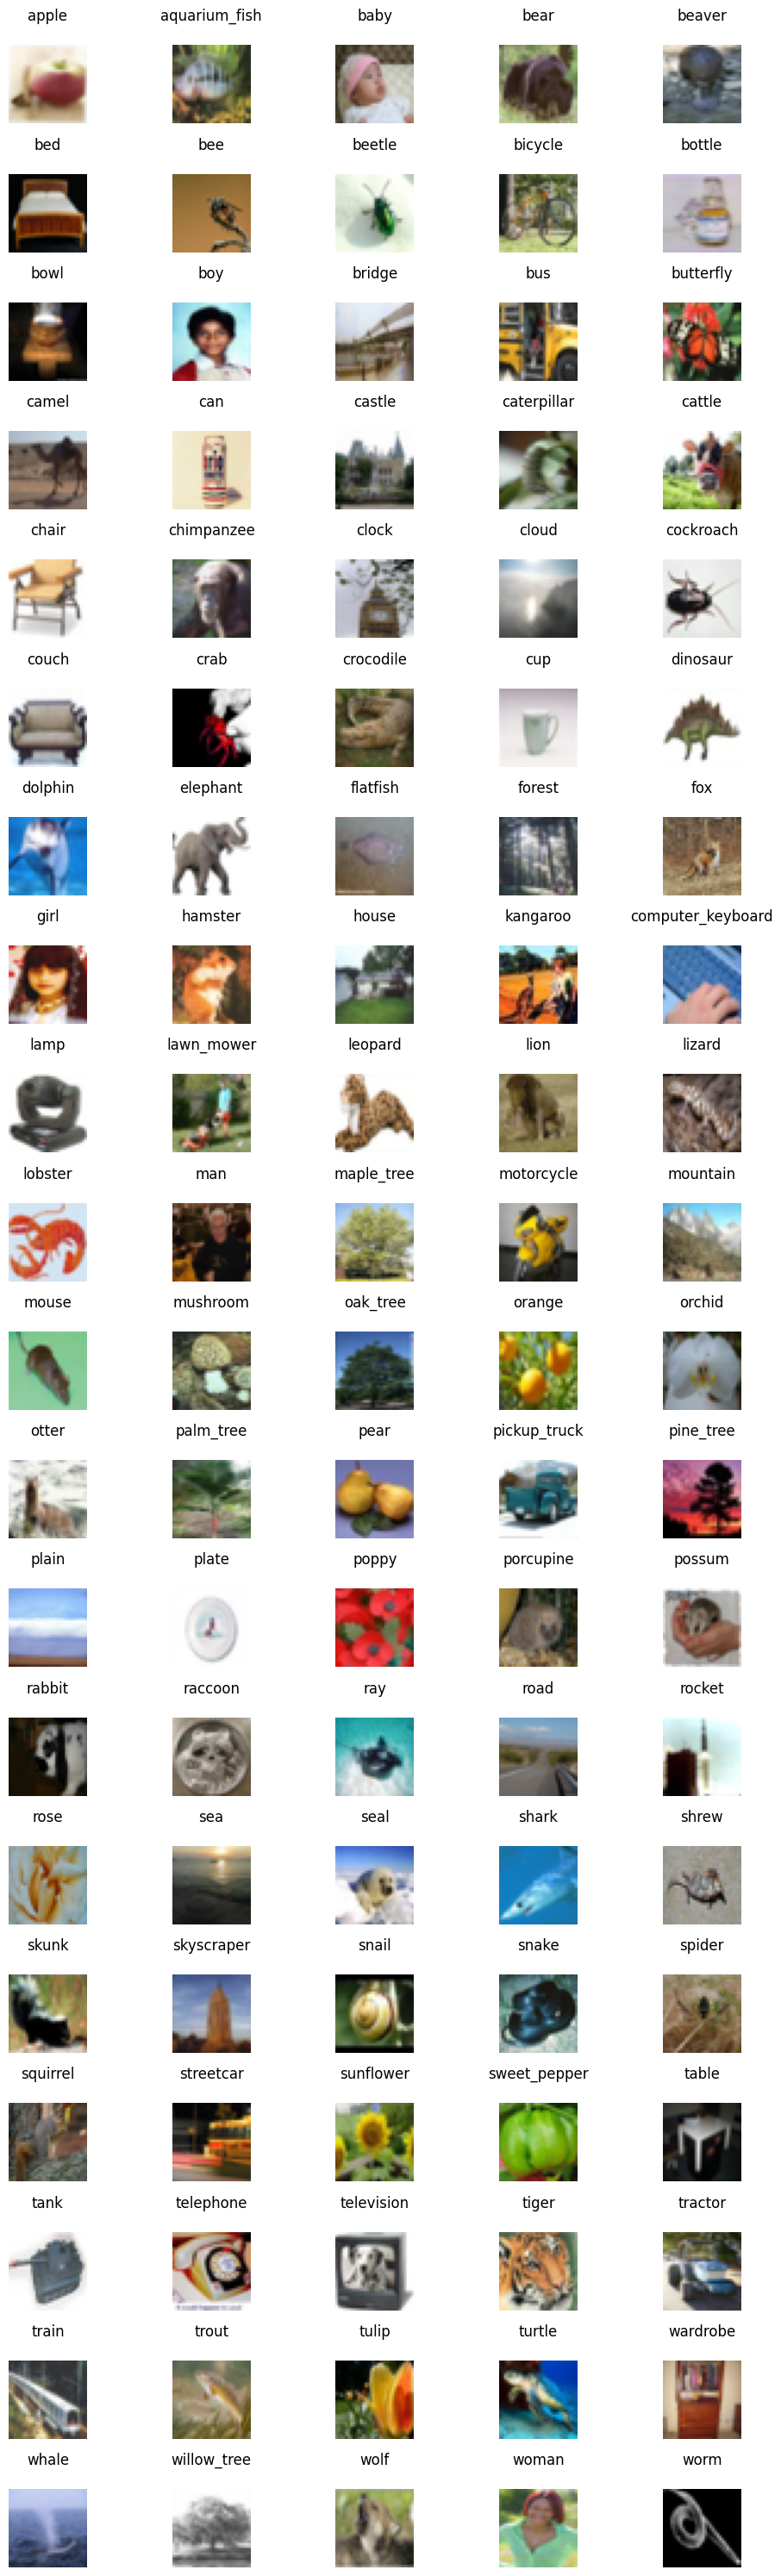

In [32]:
# create figure
fig: mpl.figure.Figure = None
ax: mpl.axes.Axes = None
fig, ax = plt.subplots(nrows=20, ncols=5, figsize=(10, 30))

i: int = 0  # i runs from 0 to (nrows*ncols-1) = 99
axi: mpl.axes.Axes = None  # axi is equivalent with ax[rowid][colid]

# for each fine label add an image to plot
for i, axi in enumerate(ax.flat):
    # get first index of image with with fine label i
    index: int = np.where(y_train.reshape(y_train.shape[0]) == i)[0][0]
    # get first image with fine label i
    img: np.ndarray = x_train[index]
    # add image to subplot
    axi.imshow(img)
    # remove axis from image
    axi.axis('off')
    # write title of image
    axi.set_title(f"{y_train_str[index][0]}\n")

fig.tight_layout()
plt.show()

Finally let's take a look at our find labels balance:

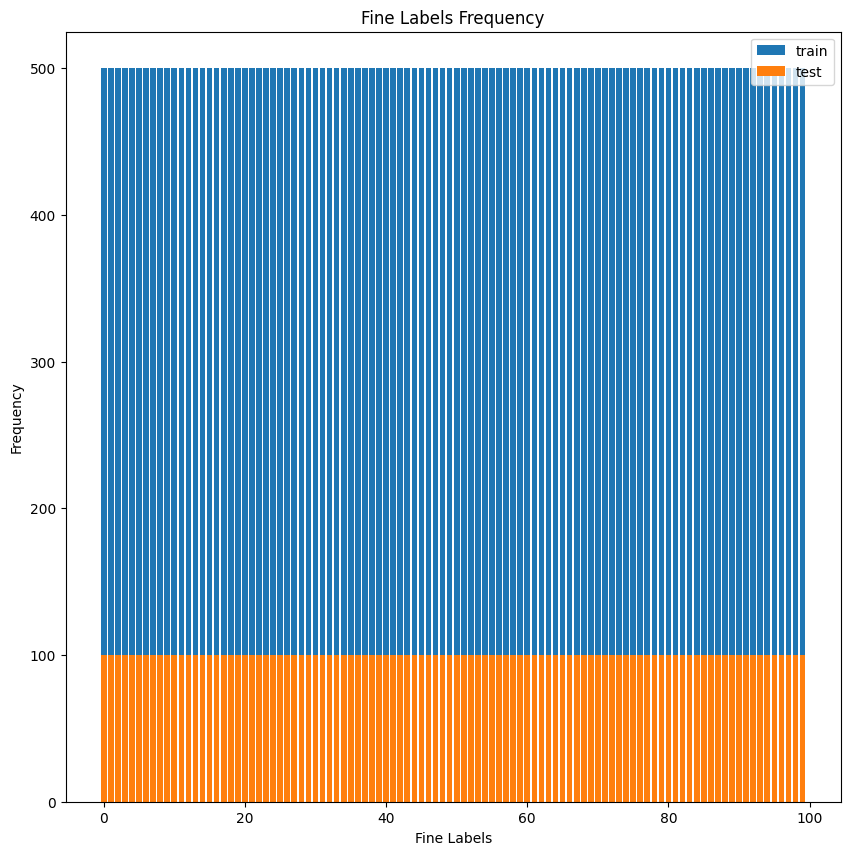

In [58]:
unique: np.ndarray = None
counts: int = 0

plt.figure(figsize=(10, 10))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, label='train')
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts, label='test')

plt.title('Fine Labels Frequency')
plt.xlabel('Fine Labels')
plt.ylabel('Frequency')

plt.legend()
plt.show()

We can see the test and train data is perfectly balanced with fine labels.

## ***Fast Text Vectors EDA***

First we need to download and load the fast text vectors:

In [34]:
fast_text_vectors: gs.models.keyedvectors = gdownloader.load(
    "fasttext-wiki-news-subwords-300")

We can see from the fine labels list above that each label is a word or multiple words separated by _ . we will create for each fine label an average vector of its words. first see each label as a word list:

In [35]:
fine_labels_words: List[List[str]] = list(
    map(tf.keras.preprocessing.text.text_to_word_sequence, fine_labels))

word_list: List[str] = None
for word_list in fine_labels_words:
    print(word_list)

['apple']
['aquarium', 'fish']
['baby']
['bear']
['beaver']
['bed']
['bee']
['beetle']
['bicycle']
['bottle']
['bowl']
['boy']
['bridge']
['bus']
['butterfly']
['camel']
['can']
['castle']
['caterpillar']
['cattle']
['chair']
['chimpanzee']
['clock']
['cloud']
['cockroach']
['couch']
['crab']
['crocodile']
['cup']
['dinosaur']
['dolphin']
['elephant']
['flatfish']
['forest']
['fox']
['girl']
['hamster']
['house']
['kangaroo']
['computer', 'keyboard']
['lamp']
['lawn', 'mower']
['leopard']
['lion']
['lizard']
['lobster']
['man']
['maple', 'tree']
['motorcycle']
['mountain']
['mouse']
['mushroom']
['oak', 'tree']
['orange']
['orchid']
['otter']
['palm', 'tree']
['pear']
['pickup', 'truck']
['pine', 'tree']
['plain']
['plate']
['poppy']
['porcupine']
['possum']
['rabbit']
['raccoon']
['ray']
['road']
['rocket']
['rose']
['sea']
['seal']
['shark']
['shrew']
['skunk']
['skyscraper']
['snail']
['snake']
['spider']
['squirrel']
['streetcar']
['sunflower']
['sweet', 'pepper']
['table']
['tank'

Next let's validate each word is in the fast text vector corpus:

In [36]:
word_list: List[str] = None
word: str = ''
for word_list in fine_labels_words:
    for word in word_list:
        try:
            fast_text_vectors.word_vec(word)
        except Exception as err:
            print(f"-----{word} isn't in corpus----")

C:\Users\Yogant\AppData\Local\Temp\ipykernel_28504\1129520586.py:6: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  fast_text_vectors.word_vec(word)


As we can see every word has a vector so let's turn each word to its average vector of its words:

In [37]:
def word_list_to_avg_vector(lst: List[str]) -> np.ndarray:
    """
    Transform a word list to its average vector
    Parameters:
        lst (List[str]): string to transform to vector
    Returns:
        np.ndarray: vector representation of word list
    """
    # create empty array
    vec: np.ndarray = np.array([0.0] * 300)

    word: str = ''
    for word in lst:
        # add word vector to sentence vectors or zero if no word vector
        vec += fast_text_vectors.word_vec(word)

    # return average vector (take sentence length into consideration)
    return vec / len(lst)


fine_labels_vecs = np.asarray(list(
    map(word_list_to_avg_vector, fine_labels_words)))

print(f"fine labels vectors shape: {fine_labels_vecs.shape}")

fine labels vectors shape: (100, 300)


C:\Users\Yogant\AppData\Local\Temp\ipykernel_28504\2881441559.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vec += fast_text_vectors.word_vec(word)


Now let's look at the similarity between each fine label vector, this can help us understand which classes can be predicted wrongly because of their similarity. We will use cosine similarity because it is a similarity measure rather than a distance measure meaning The larger the similarity, the "closer" the word embeddings are to each other. In our process we are going to try and predict the image word vector and then get its class by similarity so if the fine labels are close by similarity it can cause confusion and errors. let's take a look at the similarity between each class:

In [38]:
# calculate cosine similarity between each two labels
similarity_matrix: np.ndarray = skpairwise.cosine_similarity(
    fine_labels_vecs, fine_labels_vecs)

# get only lower triangle
similarity_matrix: np.ndarray = np.tril(similarity_matrix, -1)

# get indexes with cosine similarity greater than 0.65
indexes: np.ndarray = np.argwhere(similarity_matrix > 0.65)

# create dataframe for better printing
fine_labels_high_similarity: pd.DataFrame = pd.DataFrame(
    {'Fine Label 1': [fine_labels[i[0]] for i in indexes],
     'Fine Label 2':  [fine_labels[i[1]] for i in indexes],
     'cosine similarity': [similarity_matrix[i[0], i[1]] for i in indexes]
     }
)

print("Fine labels with high cosine"
      "similarity and the cosine similarity value:\n"
      f"{fine_labels_high_similarity}")

Fine labels with high cosinesimilarity and the cosine similarity value:
   Fine Label 1   Fine Label 2  cosine similarity
0   caterpillar         beetle           0.669192
1      flatfish  aquarium_fish           0.677935
2          girl            boy           0.877364
3          lion       elephant           0.674919
4          lion        leopard           0.658242
5       lobster  aquarium_fish           0.657508
6       lobster           crab           0.755076
7           man            boy           0.674776
8    motorcycle        bicycle           0.769175
9      oak_tree     maple_tree           0.859224
10    palm_tree     maple_tree           0.815535
11    palm_tree       oak_tree           0.781855
12         pear          apple           0.689759
13    pine_tree         forest           0.705450
14    pine_tree     maple_tree           0.882768
15    pine_tree       oak_tree           0.881114
16    pine_tree      palm_tree           0.831227
17        snake      crocodi

We have 35 These pairs have a high chance of being predicted wrongly, but if we look carefully some of them are from the same family of words so it's pretty obvious that they can get mixed up. let's remove all pairs with the same coarse label:

In [39]:
fine_id_to_coarse_id: Dict[int, int] = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3,
    11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7, 19: 11,
    20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15, 28: 3,
    29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9,
    38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14,
    47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12, 64: 12,
    65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0, 73: 1,
    74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
    82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18,
    91: 1, 92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
}

# get indexes with cosine similarity greater than 0.6
indexes: np.ndarray = np.argwhere(similarity_matrix > 0.65)

# remove all indexes with same coarse label
indexes: np.ndarray = np.asarray(list(
    filter(lambda x: fine_id_to_coarse_id[x[0]] !=
           fine_id_to_coarse_id[x[1]], indexes)))

# create dataframe for better printing
fine_labels_high_similarity: pd.DataFrame = pd.DataFrame(
    {'Fine Label 1': [fine_labels[i[0]] for i in indexes],
     'Fine Label 2':  [fine_labels[i[1]] for i in indexes],
     'cosine similarity': [similarity_matrix[i[0], i[1]] for i in indexes]
     }
)

print("Fine labels with high cosine"
      "similarity and the cosine similarity value:\n"
      f"{fine_labels_high_similarity}")

Fine labels with high cosinesimilarity and the cosine similarity value:
   Fine Label 1   Fine Label 2  cosine similarity
0          lion       elephant           0.674919
1       lobster  aquarium_fish           0.657508
2     pine_tree         forest           0.705450
3        spider    caterpillar           0.667407
4        spider          snake           0.677436
5      squirrel      porcupine           0.666970
6      squirrel        raccoon           0.683283
7         tiger      crocodile           0.663161
8         tiger       elephant           0.716210
9       tractor   pickup_truck           0.658884
10        whale          shark           0.672718


We have 10 pairs with a high chance of being predicted wrongly. Finally let's create our new classes to predict. for each image instead of its class we want to predict its vectors making this a regression problem:

In [40]:
y_train_vecs: np.ndarray = np.asarray(
    [fine_labels_vecs[label] for label in y_train])
y_train_vecs: np.ndarray = y_train_vecs.reshape((50000, 300))
y_test_vecs: np.ndarray = np.asarray(
    [fine_labels_vecs[label] for label in y_test])
y_test_vecs: np.ndarray = y_test_vecs.reshape((10000, 300))

print(f"Train fine labels vectors shape: {y_train_vecs.shape}")
print(f"Test fine labels vectors shape: {y_test_vecs.shape}")

Train fine labels vectors shape: (50000, 300)
Test fine labels vectors shape: (10000, 300)


## ***Building The Model (A Deep Neural Network)***

We will create a deep neural network model to predict for each image its label vector using transfer learning with a pre-trained vgg19 model.

We begin with pre processing the images:

In [41]:
input_train: np.ndarray = tf.keras.applications.vgg19.preprocess_input(x_train)
input_test: np.ndarray = tf.keras.applications.vgg19.preprocess_input(x_test)

Next we build the transfer learning model to predict our image embeddings:

In [42]:
!pip install --upgrade tensorflow keras


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
from tensorflow.keras import layers
import tensorflow as tf

# Create base model = VGG19
base_model: tf.keras.Model = tf.keras.applications.VGG19(
    weights='imagenet', include_top=False, 
    input_shape=(32, 32, 3), pooling='max')

# Freeze the base_model so it will not train
base_model.trainable = False

# Create new model
model: tf.keras.Model = tf.keras.models.Sequential()

# Add input layer
model.add(tf.keras.Input(shape=(32,32,3)))

# Add augmentation layers (Corrected)
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation(0.1))

# Add base model
model.add(base_model)

# Add new layers to train
model.add(tf.keras.layers.Dense(448, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(384, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(300))

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 448)                 │         229,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 384)                 │         172,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 300)                 │         115,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,542,124 (78.36 MB)

 Trainable params: 517,740 (1.98 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Now let's compile the model using cosine similarity as our loss metric (we mentioned above why we use cosine similarity). When Using this loss if the value  is a negative number between -1 and 0, 0 indicates orthogonality and values closer to -1 indicate greater similarity. The values closer to 1 indicate greater dissimilarity. 

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CosineSimilarity(axis=1))

Next let's train the model:

In [47]:
es: tf.keras.callbacks.EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.01, patience=3, mode="min",
    restore_best_weights=True)
history: tf.keras.callbacks.History = model.fit(
    input_train, y_train_vecs, epochs=10, shuffle=True, 
    batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - loss: -0.7326 - val_loss: -0.7406
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - loss: -0.7376 - val_loss: -0.7441
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 152s 122ms/step - loss: -0.7422 - val_loss: -0.7441
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 120ms/step - loss: -0.7447 - val_loss: -0.7461


Now let's visualize our model performance:

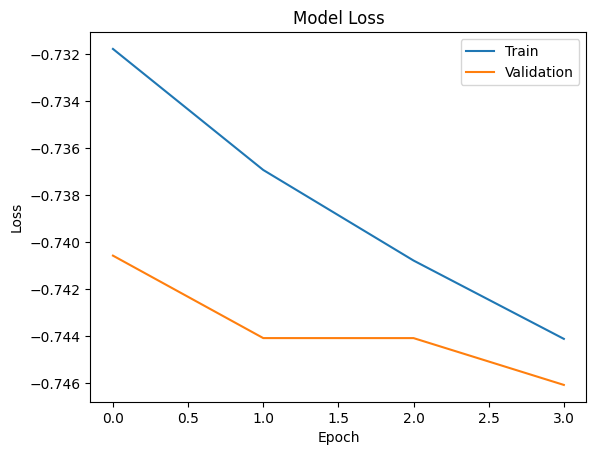

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

We can see we get a nice cosine similarity value (close to -1) and there is no overfitting. But in order to really know how good our model is we need to evaluate its performance on the test-set. Lets see how well it can predict the label vectors:

In [49]:
model_eval: float = model.evaluate(input_test, y_test_vecs) 
print(f"Model loss {model_eval}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - loss: -0.7409
Model loss -0.7411414980888367


We see that our model performs really well in predicting the label vector meaning it should predict a close enough vector. Another way to evaluate is to test the top-n labels accuracy. meaning that given an image we check if the image label is in the top-n labels we predicted. It's a little complex for us to do because a label can have synonyms and other labels that are correct and not the same text so we will be satisfied with vector prediction loss.

We saw the model evaluation, let's make some predictions using our model:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


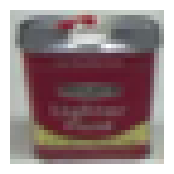

Actual label for image: can
Prediction for image: can, could, cannot, should, -can
Prediction cosine similarity to real label: 0.99

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


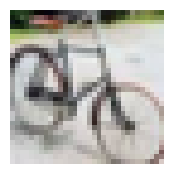

Actual label for image: bicycle
Prediction for image: bicycle, bike, motorcycle, bicyle, motor-bike
Prediction cosine similarity to real label: 0.92

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


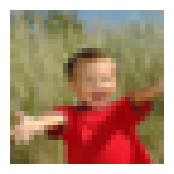

Actual label for image: boy
Prediction for image: boy, girl, man, woman, boytoy
Prediction cosine similarity to real label: 0.87

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


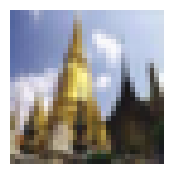

Actual label for image: castle
Prediction for image: skyscraper, tower, rocket, skyscraping, skyskraper
Prediction cosine similarity to real label: 0.61

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


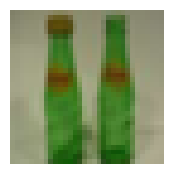

Actual label for image: bottle
Prediction for image: bottle, bottles, water-bottle, half-bottle, flask
Prediction cosine similarity to real label: 0.99

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


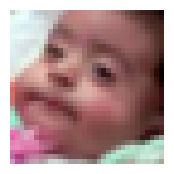

Actual label for image: baby
Prediction for image: baby, boy, girl, boytoy, boy-child
Prediction cosine similarity to real label: 0.85

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


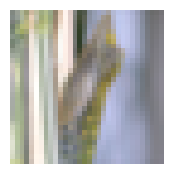

Actual label for image: caterpillar
Prediction for image: caterpillar, spider, beetle, caterpillar-like, spiderling
Prediction cosine similarity to real label: 0.89

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


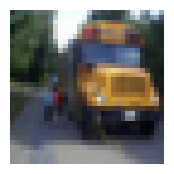

Actual label for image: bus
Prediction for image: truck, bus, car, streetcar, trolley
Prediction cosine similarity to real label: 0.83

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


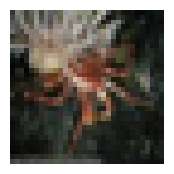

Actual label for image: crab
Prediction for image: crab, lobster, fish, garfish, blobfish
Prediction cosine similarity to real label: 0.86

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


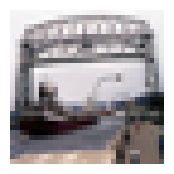

Actual label for image: bridge
Prediction for image: bus, streetcar, bus-train, trolley, tram
Prediction cosine similarity to real label: 0.73

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


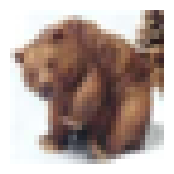

Actual label for image: bear
Prediction for image: squirrel, rabbit, raccoon, stoat, racoon
Prediction cosine similarity to real label: 0.61



In [50]:
images_index: List[int] = [25, 27, 37, 49, 52, 54, 91,
                           94, 100, 190, 396]

index: int = 0
for index in images_index:
    # get image
    img: np.ndarray = x_test[index].copy()

    # get prediction vector
    prediction: np.ndarray = model.predict(np.expand_dims(
        tf.keras.applications.vgg19.preprocess_input(img), axis=0))

    # get label id
    id: int = y_test[index][0]

    # get label
    label: str = fine_labels[id]
    
    # get label vector
    vec: np.ndarray = fine_labels_vecs[id]

    # get top-n labels by cosine similarity
    most_similar: List[str] = fast_text_vectors.similar_by_vector(
        prediction[0], topn=5)

    # display image
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # print actual label
    print(f"Actual label for image: {label}")

    # print the predictions for image
    print(f"Prediction for image: {', '.join([x[0] for x in most_similar])}")
    
    # print prediction similarity to actual class
    print("Prediction cosine similarity to real label: "
    f"{round(skpairwise.cosine_similarity(prediction, [vec])[0][0], 2)}\n")

Let's try and predict on images with labels not in this dataset as expected from ZSL:

['D:\\zero shot learning\\Image-classification-zero-shot-learning-master\\demo_images\\tansy.jpg', 'D:\\zero shot learning\\Image-classification-zero-shot-learning-master\\demo_images\\computer_mouse.jpg', 'D:\\zero shot learning\\Image-classification-zero-shot-learning-master\\demo_images\\petunia.jpg', 'D:\\zero shot learning\\Image-classification-zero-shot-learning-master\\demo_images\\starfish.jpg', 'D:\\zero shot learning\\Image-classification-zero-shot-learning-master\\demo_images\\chimpanzee.jpg', 'D:\\zero shot learning\\Image-classification-zero-shot-learning-master\\demo_images\\rhino.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Cosine Similarity: 0.09995528029865176


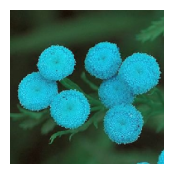

Prediction for image: squirrel, rabbit, raccoon, stoat, racoon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Cosine Similarity: 0.007063051873881383


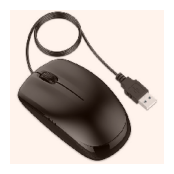

Prediction for image: squirrel, rabbit, raccoon, stoat, racoon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Cosine Similarity: 0.06734326358122432


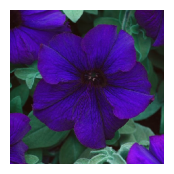

Prediction for image: squirrel, rabbit, raccoon, stoat, racoon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Cosine Similarity: 0.014550228728748614


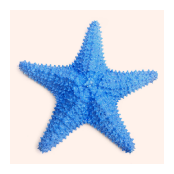

Prediction for image: squirrel, rabbit, raccoon, stoat, racoon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Cosine Similarity: 0.0076056146887729615


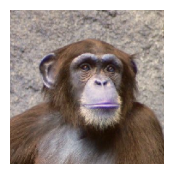

Prediction for image: squirrel, rabbit, raccoon, stoat, racoon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Cosine Similarity: 0.039826497067386335


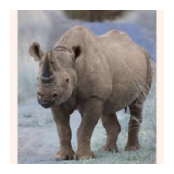

Prediction for image: squirrel, rabbit, raccoon, stoat, racoon


In [69]:
import os
from sklearn.metrics.pairwise import cosine_similarity

# Define the correct image paths
images_paths = [
    os.path.abspath('demo_images/tansy.jpg'),
    os.path.abspath('demo_images/computer_mouse.jpg'),
    os.path.abspath('demo_images/petunia.jpg'),
    os.path.abspath('demo_images/starfish.jpg'),
    os.path.abspath('demo_images/chimpanzee.jpg'),
    os.path.abspath('demo_images/rhino.jpg')
]

print(images_paths)

# Loop through each image
for img_path in images_paths:
    if not os.path.exists(img_path):
        print(f"Error: {img_path} not found!")
        continue  # Skip this image if not found

    # Load image and resize to (224, 224)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

    # Convert image to numpy array
    img_array = np.asarray(img)

    # Preprocess image for VGG19
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)

    # Expand dimensions to match model input (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Get prediction vector from VGG19 model
    prediction = model.predict(img_array)  # Shape: (1, 1000)

    # Assuming fast_text_vectors.similar_by_vector returns a 300-dimensional vector
    fast_text_vector = np.random.random(300)  # Just an example fastText vector, replace with actual
    
    # If the fast_text_vector is 300-dimensional, we can adjust its dimensionality
    # Use PCA, SVD, or another dimensionality reduction technique to make it 1000-dimensional
    # Here's an example of padding it with zeros (you can replace this with your dimensionality reduction logic)
    
    if fast_text_vector.shape[0] != 1000:
        # Resize fastText vector to match VGG19 output shape (1000,)
        fast_text_vector_resized = np.resize(fast_text_vector, (1000,))
    else:
        fast_text_vector_resized = fast_text_vector
    
    # Now both vectors have shape (1000,)
    similarity = cosine_similarity(prediction[0].reshape(1, -1), fast_text_vector_resized.reshape(1, -1))
    
    # Print the similarity
    print(f"Cosine Similarity: {similarity[0][0]}")
    
    # Display the image
    plt.figure(figsize=(2, 2))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))  # Convert back to image
    plt.axis('off')
    plt.show()

    # Print top-5 predictions
    print(f"Prediction for image: {', '.join([x[0] for x in most_similar])}")


We can see our predictions for images not in our dataset are pretty good. Finally lets save our model for later use:

In [24]:
model.save("model.h5")